## **NAME**: KARTHIK SANKHAR V
## **REG.NO**: 21MIA1152

## **Step 1:** Feature Extraction from Segmented Objects

### **1.	Segment the Image**

In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Original image


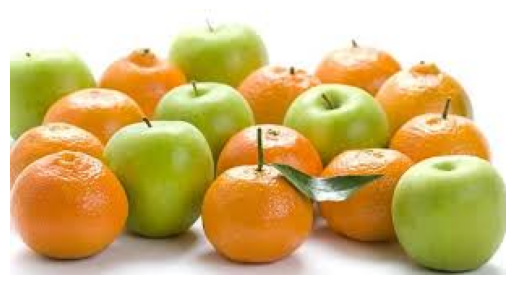

In [2]:
image = cv2.imread('images.jpeg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print('Original image')
plt.axis('off')
plt.show()

HSV image


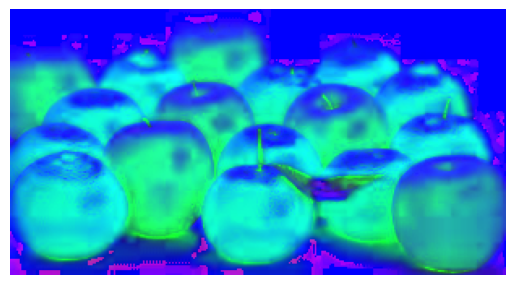

In [3]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.imshow(hsv_image)
print('HSV image')
plt.axis('off')
plt.show()

segmented objects


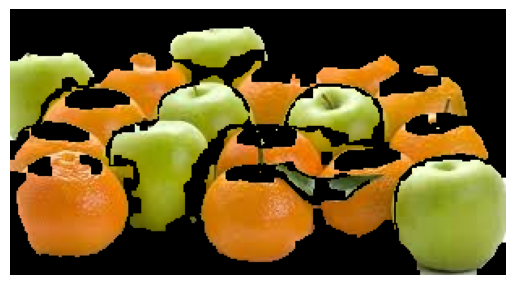

In [4]:
kernel = np.ones((5, 5), np.uint8)
lower_orange = np.array([5, 150, 150])
upper_orange = np.array([25, 255, 255])
mask_orange = cv2.inRange(hsv_image, lower_orange, upper_orange)
mask_orange = cv2.morphologyEx(mask_orange, cv2.MORPH_CLOSE, kernel)
segmented_oranges = cv2.bitwise_and(image, image, mask=mask_orange)
lower_green = np.array([30, 40, 40])
upper_green = np.array([85, 255, 255])
mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)
segmented_green_apples = cv2.bitwise_and(image, image, mask=mask_green)
combined_mask = cv2.bitwise_or(mask_orange, mask_green)
segmented_image = cv2.bitwise_and(image, image, mask=combined_mask)
color_segmented_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)


plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
print('segmented objects')
plt.axis('off')
plt.show()


### **2.	Identify the Objects of Interest**

Segmented Image with Contours


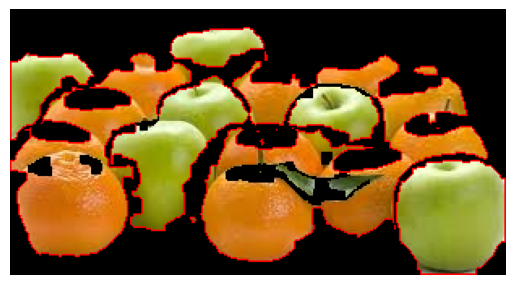

In [5]:
contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(segmented_image, contours, -1, (0, 0, 255), 1) 

plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
print('Segmented Image with Contours')
plt.axis('off')
plt.show()

### **3.Extract Features from Each Object**

In [6]:
from skimage.feature import graycomatrix, graycoprops
contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
areas = []
perimeters = []
mean_colors = []
texture_features = []
color_labels = []
def classify_color(mean_color):
    b, g, r = mean_color
    if r > g and r > b:  # Simplified logic for orange
        return 'Orange'
    elif g > r and g > b:  # Simplified logic for green
        return 'Green apple'
    else:
        return 'Unknown'
color_segmented_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

for c in contours:
    area = cv2.contourArea(c)
    perimeter = cv2.arcLength(c, True)
    areas.append(area)
    perimeters.append(perimeter)
    object_mask = np.zeros_like(combined_mask)
    cv2.drawContours(object_mask, [c], -1, 255, thickness=cv2.FILLED)
    mean_color = cv2.mean(image, mask=object_mask)[:3]
    mean_colors.append(mean_color)
    color_label = classify_color(mean_color)
    color_labels.append(color_label)
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    texture_features.append((contrast, energy, homogeneity))

In [7]:
for i, cnt in enumerate(contours):
    print(f"  Area: {areas[i]}")
    print(f"  Perimeter: {perimeters[i]}")
    print(f"  Mean Color (BGR): {mean_colors[i]}")
    print(f"  Texture Features (Contrast, Energy, Homogeneity): {texture_features[i]}")
    print()

  Area: 0.0
  Perimeter: 4.0
  Mean Color (BGR): (50.0, 134.66666666666666, 154.66666666666666)
  Texture Features (Contrast, Energy, Homogeneity): (111.34892043182728, 0.13935501941329573, 0.4134757714836218)

  Area: 6.5
  Perimeter: 10.242640614509583
  Mean Color (BGR): (47.25, 100.91666666666666, 98.16666666666666)
  Texture Features (Contrast, Energy, Homogeneity): (111.34892043182728, 0.13935501941329573, 0.4134757714836218)

  Area: 3988.5
  Perimeter: 246.1248903274536
  Mean Color (BGR): (76.52949780594831, 170.47879083373962, 157.55972696245732)
  Texture Features (Contrast, Energy, Homogeneity): (111.34892043182728, 0.13935501941329573, 0.4134757714836218)

  Area: 2.0
  Perimeter: 7.656854152679443
  Mean Color (BGR): (129.16666666666666, 179.33333333333331, 175.33333333333331)
  Texture Features (Contrast, Energy, Homogeneity): (111.34892043182728, 0.13935501941329573, 0.4134757714836218)

  Area: 0.0
  Perimeter: 2.0
  Mean Color (BGR): (96.0, 129.5, 129.0)
  Texture Fea

### **4.	Analyze and Use the Features**

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.75      1.00      0.86         9

    accuracy                           0.77        13
   macro avg       0.88      0.62      0.63        13
weighted avg       0.83      0.77      0.72        13

Object Recognition


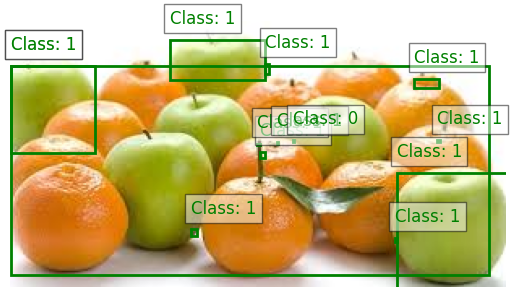

In [8]:
data = {
    'Area': areas,
    'Perimeter': perimeters,
    'Mean Color B': [color[0] for color in mean_colors],
    'Mean Color G': [color[1] for color in mean_colors],
    'Mean Color R': [color[2] for color in mean_colors],
    'Contrast': [feature[0] for feature in texture_features],
    'Energy': [feature[1] for feature in texture_features],
    'Homogeneity': [feature[2] for feature in texture_features],
}

df = pd.DataFrame(data)
labels = np.array([0 if label == 'Orange' else 1 for label in color_labels])
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.3, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(df)
print(classification_report(labels, predictions))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots()
plt.imshow(image_rgb)
for i, c in enumerate(contours):
    x, y, w, h = cv2.boundingRect(c)
    rect = plt.Rectangle((x, y), w, h, edgecolor='green', facecolor='none', linewidth=2)
    ax.add_patch(rect)
    ax.text(x, y - 10, f"Class: {predictions[i]}", color='green', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
ax.axis('off')
print('Object Recognition')
plt.show()

## **Step 2 :** Object Detection using the extracted features

Object Detection using the extracted features


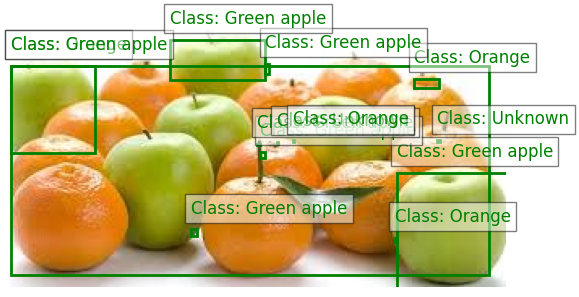

In [10]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
plt.imshow(image_rgb)
for i, c in enumerate(contours):
    x, y, w, h = cv2.boundingRect(c)
    rect = plt.Rectangle((x, y), w, h, edgecolor='green', facecolor='none', linewidth=2)
    ax.add_patch(rect)
    ax.text(x, y - 10, f"Class: {color_labels[i]}", color='green', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
ax.axis('off')
print('Object Detection using the extracted features')
plt.show()